In [13]:
#%load_ext Cython

/Users/Joseph/anaconda2/lib/python2.7/site-packages/IPython/extensions/cythonmagic.py:21: UserWarning: The Cython magic has been moved to the Cython package
  warnings.warn("""The Cython magic has been moved to the Cython package""")


In [7]:
import pandas as pd
import numpy as np
import scipy.io as scio
import seaborn as sns

In [ ]:
def BOLD(T,r):
    dt  = 0.001; 
    t0  = np.arange(0,T+dt,dt)
    n_t = t0.shape[0]
    t_min = 20;
    n_min = int(np.around(t_min/dt))-1
    r_max = np.max(r);

    #BOLD model parameters
    taus   = 0.65; # 0.8;    % time unit (s)
    tauf   = 0.41; # 0.4;    % time unit (s)
    tauo   = 0.98; # 1;      % mean transit time (s)
    alpha  = 0.32; # 0.2;    % a stiffness exponent
    itaus  = 1/taus;
    itauf  = 1/tauf;
    itauo  = 1/tauo;
    ialpha = 1/alpha;
    Eo     = 0.34; # 0.8;    % resting oxygen extraction fraction
    vo     = 0.02;
    k1     = 7*Eo; 
    k2     = 2; 
    k3     = 2*Eo-0.2;

    # Initial conditions
    x0 = np.array([0,1,1,1])
    t = t0;
    x = np.zeros([n_t,4])
    x[0,:] = x0;

    for n in np.arange(0,n_t-2):
                #print n
                #print(n)
                #print(r.shape)
                r[n-1]
                x[n+1,0] = x[n,0] + dt*( r[n]-itaus*x[n,0]-itauf*(x[n,1]-1) );
                x[n+1,1] = x[n,1] + dt*x[n,0];
                x[n+1,2] = x[n,2] + dt*itauo*(x[n,1]-x[n,2]**ialpha);
                x[n+1,3] = x[n,3] + dt*itauo*(x[n,1]*(1-(1-Eo)**(1/x[n,1]))/Eo - (x[n,2]**ialpha)*x[n,3]/x[n,2]);
                
    t  = t[n_min:];
    s  = x[n_min:,0];
    fi = x[n_min:,1];
    v  = x[n_min:,2];
    q  = x[n_min:,3];
    b  = 100/Eo*vo*( k1*(1-q) + k2*(1-q/v) + k3*(1-v) );
    b = b[~np.isnan(b)]
    if np.argwhere(np.isnan(b)).shape[0]!=0:
        print 'nan detected!!! Index: ', np.argwhere(np.isnan(b))
    
    return b #100/Eo*vo*( k1*(1-q) + k2*(1-q/v) + k3*(1-v) );



In [ ]:
def phie(x):
    g=0.16;
    I=125.;
    c=310.;
    y=c*x-I;
    #y./(1-exp(-g*y));
    return y/(1-np.exp(-g*y))

def phii(x):
    g=0.087;
    I=177.;
    c=615.; 
    y=c*x-I;
    return y/(1-np.exp(-g*y));

In [12]:
#%%cython

def TVBPy(C, wee, tmax, sigma, JN, gamma):
    
    # function inputs:
    # - structural connectivity C
    # - coupling factor wee
    # - simulation length tmax in miliseconds
    # - excitatory synaptic coupling
    # - white matter speed
    #
    # runs TVBii simulation (no FIC)
    # returns raw simulated timecourses as a numpy array

    #------------------------------------------------------------------    
    # SET PARAMETERS
    #------------------------------------------------------------------
    
    
    
    # define types of variables to speed up cython
    #cdef int Nnew, ddt, ds, dt, tspan, taon, taog, J, I0, Jexte, Jexti, w, neuro_act, sn, sg, nn, j, T, B, BOLD, BOLD_act
    
    Nnew = C.shape[1]
    dtt = 1e-3 # Sampling rate of simulated neuronal activity (seconds)
    ds = 100 # BOLD downsampling rate
    dt = 0.1
    #tmax = 30000 # simulation length in ms
    tspan = np.arange(0,tmax,dt)
    taon=100;
    taog=10;
    #gamma=0.641;
    #sigma=0.001;
    #JN=0.15;
    #J=ones(Nnew,1);
    J = np.ones(Nnew) # or np.ones([Nnew,1])
    I0=0.382;
    Jexte=1.;
    Jexti=0.7;
    w=1.4;
    #wee=1.0; # is this G? coupling factor?
    neuro_act = np.zeros([tmax,Nnew])
    #print(neuro_act.shape)
    #sn=0.001*ones(Nnew,1);
    sn = 0.001*np.ones(Nnew) # or np.ones([Nnew,1]) ?
    #sg=0.001*ones(Nnew,1);
    sg = 0.001*np.ones(Nnew) # or np.ones([Nnew,1]) ?
    nn=0;
    j=0;
    
    #------------------------------------------------------------------    
    # RUN SIMULATION
    #------------------------------------------------------------------
    print 'Caluclating steps...'
    for i in range(0,tspan.shape[0]):
        #clear_output(wait=True)
        #print i 
        #print 'Coupling factor wee:', wee
        xn=I0*Jexte+w*JN*sn+wee*JN*np.dot(C,sn)-J*sg # Deco2014 - equation 5
        xg=I0*Jexti+JN*sn-sg # Deco2014 - equation 6
        rn=phie(xn) # Deco2014 - equation 7: y=c*x-I; return y/(1-np.exp(-g*y))
        rg=phii(xg) # Deco2014 - equation 8: y=c*x-I; return y/(1-np.exp(-g*y));
        sn=sn+dt*(-sn/taon+(1-sn)*gamma*rn/1000)+(dt)*sigma*np.random.randn(Nnew) # Deco2014 - equation 9
        sn[sn>1] = 1
        sn[sn<0] = 0
        sg=sg+dt*(-sg/taog+rg/1000)+(dt)*sigma*np.random.randn(Nnew) # Deco2014 - equation 10
        sg[sg>1] = 1
        sg[sg<0] = 0
        j = j + 1
        if j==10:
            neuro_act[nn,:] = sn
            nn = nn + 1
            j = 0
    
    nn = nn - 1
    T = (nn+1)*dtt # Total time in seconds
    B = BOLD(T,neuro_act[0:nn,0])
    BOLD_act = np.zeros([B.shape[0], Nnew])
    BOLD_act[:,0] = B

    for nnew in range(1,Nnew):
        B = BOLD(T, neuro_act[0:nn,nnew])
        BOLD_act[:,nnew]=B

    i = np.arange(500,BOLD_act.shape[0],ds)
    bds = BOLD_act[i,:]
    return {'bds':bds, 'neuro_act':neuro_act} 


In [9]:
#emp_data = scio.loadmat('/Users/Joseph/Desktop/TVBii/Test_TVBii_in_Python/test_SC.mat')
#emp_data
#my_id = 'test_SC'
#C = emp_data['sc_cap']

In [10]:
#a = TVBPy(C,1.0)
#%matplotlib inline
#sns.tsplot(a.T, err_style="unit_traces")

/Users/Joseph/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:45: RuntimeWarning: invalid value encountered in divide


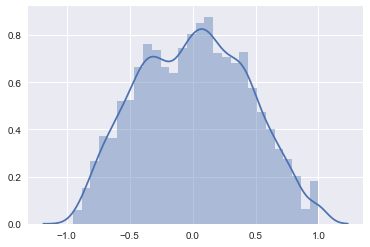

In [16]:
#my_mat = np.corrcoef(a.T) # Each row of `x` represents a variable, each column a single observation
#r = my_mat.flatten()
#sns.distplot(r)